## Imports

In [1]:
import bertFuncs as func
from functions import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from transformers import logging
logging.set_verbosity_error()
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
from nltk.corpus import wordnet as wn

from scipy.stats import ttest_ind

## 1. Get Embeddings

### 1.1 Get Firm Embeddings

In [276]:
# Read S&P500 company names.
# Source: https://github.com/datasets/s-and-p-500-companies/blob/master/data/constituents.csv

company_names = pd.read_csv("sp500.csv")
#company_names["Count"] = company_names['Name'].str.split().apply(len)
#company_names.rename(columns = {"cleanedname":"Name"}, inplace = True)

In [453]:
def get_average_embedding(target_list, context): 
    
    for entry in target_list: 
        
        names = entry.split(" ")
        
        # Get contextual embedding for each part of the name.  
        embeddings = pd.DataFrame()
        for name in names: 
            embeddings[[f"{name}_male", f"{name}_female", "tuple"]] = get_firm_embeddings(name, context, 111, "all")[["Value 1", "Value 2", "tuple"]]

        # Take average of different name parts. 
        embeddings["average_male"] = embeddings.loc[:, embeddings.columns.str.endswith('_male')].mean(axis=1).round(7)
        embeddings["average_female"] = embeddings.loc[:, embeddings.columns.str.endswith('_female')].mean(axis=1).round(7)

        # Calculate delta / bias. 
        embeddings["female-male"] = (embeddings["average_female"] - embeddings["average_male"]).round(7)

        # Store for faster import later. 
        embeddings.to_csv(f"./averaged_embeddings/{entry}.csv")

In [ ]:
# Get embeddings for S&P 500 names. Average embeddings are calculated for multi-word firms. 

get_average_embedding(company_names["Name"], "works")

### 1.1 Get Random Noun Embeddings

In [326]:
# Load and clean list of english nouns and generate random sample.

nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 500, random_state = 42)
nouns_sample = list(nouns_sample)

# Make sure no overlap between nouns and companies 
company_names["Name_Lower"] = company_names['Name'].str.lower()
nouns_sample = [x for x in nouns_sample if x not in list(company_names["Name_Lower"])]

In [280]:
# Get embeddings for random nouns. 

get_average_embedding(nouns_sample, "works")

  0%|          | 0/500 [00:00<?, ?it/s]

## 2. Initial analysis

In [329]:
# Get all considered dimensions. 

dimensions = get_firm_embeddings("amazon", "works", 111, "all")

all_dimensions = dimensions["tuple"]

In [282]:
len(all_dimensions)

101

In [489]:
len(all_dimensions.unique())

101

### 2.1 Distribution Plots

In [470]:
def get_dimension_distribution(considered_companies, antonym_pair, nouns_sample): 
    
    result = read_embedding_values(considered_companies, antonym_pair)
    rand_result = read_embedding_values(nouns_sample, antonym_pair)
    

    fig = plt.figure(constrained_layout=True, figsize=(12, 6))
    
    gs = GridSpec(2, 1, figure=fig)
    fig.suptitle(f"Distributions for {str(antonym_pair)}", weight="bold")

    # Plot male and female distribution 
    stat, p_value = ttest_ind(result["value_male"], result["value_female"])
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title(f"Male vs. Female Firm Distribution ({check_significance(p_value)}, p-value = {round(p_value, 5)})", fontsize=9)
    sns.distplot(result["value_male"], ax = ax1, label = "Male Context", color = '#3AA8F3')
    sns.distplot(result["value_female"], ax = ax1, label = "Female Context", color = 'fuchsia')
    plt.axvline(0, color = "black", ls = "--")
    plt.axvline(result["value_male"].mean(), color = "#3AA8F3")
    plt.axvline(result["value_female"].mean(), color = "fuchsia")
    plt.legend() 
    
    # Plot difference
    stat, p_value = ttest_ind(result["difference"], rand_result["difference"])
    ax4 = fig.add_subplot(gs[1, :])
    ax4.set_title(f"Corporate vs. Random Difference ({check_significance(p_value)}, p-value = {round(p_value, 5)})", fontsize=9)
    sns.distplot(result["difference"], ax = ax4, label = "Firm difference", color = "cyan")
    sns.distplot(rand_result["difference"], ax = ax4, label = "random difference", color = "grey")
    plt.axvline(0, color = "black", ls = "--")
    plt.axvline(rand_result["difference"].mean(), color = "grey")
    plt.axvline(result["difference"].mean(), color = "cyan")
    plt.legend()
    
    plt.savefig(f'./distribution_plots/{antonym_pair}.png', bbox_inches = "tight")

In [468]:
def read_embedding_values(embedding_names, antonym_pair): 
    
    result = pd.DataFrame()
    result["companies"] = embedding_names
    result["value_male"] = 0
    result["value_female"] = 0
    result["difference"] = 0

    for embedding in embedding_names: 
        comparison = pd.read_csv(f"./averaged_embeddings/{embedding}.csv")

        comparison = comparison.groupby("tuple", as_index = False).mean() # Account for duplicates.         
        value_male = float(comparison[comparison["tuple"] == antonym_pair]["average_male"])
        value_female = float(comparison[comparison["tuple"] == antonym_pair]["average_female"])
        difference = value_female - value_male
        result["value_male"].loc[result["companies"] == embedding] = value_male
        result["value_female"].loc[result["companies"] == embedding] = value_female
        result["difference"].loc[result["companies"] == embedding] = difference
    
    return result    

In [ ]:
# Create and save plots for all dimensions. 

for dimension in all_dimensions: 
    get_dimension_distribution(company_names["Name"], str(dimension), nouns_sample)

### 2.2 P-Values

In [472]:
def get_dimension_pvalues(considered_companies, antonym_pair, nouns_sample): 
    
    result = read_embedding_values(considered_companies, antonym_pair)
    rand_result = read_embedding_values(nouns_sample, antonym_pair)
    
    stat1, p_value1 = ttest_ind(result["value_male"], result["value_female"])
    stat2, p_value2 = ttest_ind(result["difference"], rand_result["difference"])
    
    res1 = round(p_value1, 5)
    res2 = round(p_value2, 5)
    
    return [res1, res2]

### Get Complete Table

In [516]:
import math
print(math.ceil(4.2))

5


In [521]:

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [ ]:
print(math.ceil(4.2, ))

In [520]:
print(round_decimals_up(0.00000000001, 4))

0.0001


In [ ]:
considered_companies = company_names["Name"].unique()

# also tested for single-word company names 
#considered_companies = company_names[company_names["Count"] == 1]["Name"]

In [527]:
res_table = pd.DataFrame()
res_table["Dimension"] = all_dimensions.unique()
res_table["M vs. F Firm Embedding"] = 0 
res_table["Delta Firm vs. Delta Random Embedding"] = 0
res_table["Mean Firm"] = 0
res_table["Mean Random"] = 0


# Loop through all unique dimensions. 
for dimension in tqdm(all_dimensions.unique()): 
    
    
    # Get and append p-values for dimension. 
    res = get_dimension_pvalues(considered_companies, str(dimension), nouns_sample)
    
    res_table["M vs. F Firm Embedding"].loc[res_table["Dimension"] == dimension] = round_decimals_up(res[0], 5)
    res_table["Delta Firm vs. Delta Random Embedding"].loc[res_table["Dimension"] == dimension] = round_decimals_up(res[1], 5)
    

    # Get mean bias values for companies. 
    company_res = []
    
    for company in considered_companies: 
        comparison = pd.read_csv(f"./averaged_embeddings/{company}.csv")
        comparison = comparison.groupby("tuple", as_index = False).mean()
        company_res.append(float(comparison[comparison["tuple"] == str(dimension)]["female-male"]))
        
    res_table["Mean Firm"].loc[res_table["Dimension"] == dimension] = (sum(company_res) / len(company_res))
    
    
    
    # Get mean bias values for random nouns. 
    noun_res = []
    
    for noun in nouns_sample: 
        comparison = pd.read_csv(f"./averaged_embeddings/{noun}.csv")
        comparison = comparison.groupby("tuple", as_index = False).mean()
        noun_res.append(float(comparison[comparison["tuple"] == str(dimension)]["female-male"]))
        
    res_table["Mean Random"].loc[res_table["Dimension"] == dimension] = (sum(noun_res) / len(noun_res))
    
    res_table["Mean Firm vs. Mean Random"] = res_table["Mean Firm"] - res_table["Mean Random"]

  0%|          | 0/101 [00:00<?, ?it/s]

In [528]:
res_table.head()

,Dimension,M vs. F Firm Embedding,Delta Firm vs. Delta Random Embedding,Mean Firm,Mean Random,Mean Firm vs. Mean Random
0,"(confident, shy)",0.70249,0.53047,-0.036353,-0.048086,0.011733
1,"(open, distant)",0.00006,0.54879,-0.220173,-0.230553,0.010380
2,"(creative, uncreative)",0.44179,0.20987,0.030286,0.016643,0.013643
3,"(aggressive, submissive)",0.22253,0.00054,0.062463,0.005635,0.056828
4,"(sincere, insincere)",0.52709,0.00000,0.075201,-0.034869,0.110070


In [533]:
len(res_table[res_table["M vs. F Firm Embedding"] < 0.05])

51

In [479]:
# Filter p-values. 

sign_level = 0.05

res_all_df_filtered = res_all_df.loc[
                    (res_all_df["Male vs. Female Corporate Embedding"] < sign_level) 
                     &(res_all_df["Difference Firm vs. Difference Random"] < sign_level) 
                    ]

### Get Dictionary Results for Companies

In [624]:
# Read and prepare dictionaries. 

dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries["tuple"] = list(zip(dictionaries["Term1"].astype(str), dictionaries["Term2"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

unique_dictionaries = dictionaries["Dictionary"].unique()
unique_dictionaries.sort()

In [627]:
def get_dictionary_average(target_list, scope):
    
    result_dict = {}
    result_dict["Name"] = []

    for dictionary in unique_dictionaries: 
        result_dict[f"{dictionary}_Male"] = []
        result_dict[f"{dictionary}_Female"] = []
        result_dict[f"{dictionary}_Female-Male"] = []

    result = pd.DataFrame(result_dict)
    
    for name in target_list: 
        comparison = pd.read_csv(f"./averaged_embeddings/{name}.csv", index_col = 0)
        comparison = comparison.sort_index()
        comparison = pd.concat([comparison, dictionaries], axis=1) 

        comparison = comparison.groupby("Dictionary", as_index = False, ).mean()
        comparison = comparison.iloc[:,-3:]
        values = [item for sublist in comparison.values for item in sublist]
        values.insert(0, name)
        result.loc[len(result)] = values 
           
    if scope == "full":
        return result 
    
    if scope == "limited":
        return result.loc[:, x.columns.str.endswith('Female-Male')]

In [628]:
x = get_dictionary_average(company_names["Name"], "full")

In [629]:
x.head()

,Name,Ability_Male,Ability_Female,Ability_Female-Male,Agency_Male,Agency_Female,Agency_Female-Male,Morality_Male,Morality_Female,Morality_Female-Male,Politics_Male,Politics_Female,Politics_Female-Male,Sociability_Male,Sociability_Female,Sociability_Female-Male,Status_Male,Status_Female,Status_Female-Male
0,3M,-0.607757,-0.546584,0.061173,0.417957,0.361829,-0.056129,-0.181350,-0.175099,0.006251,-0.352764,-0.142683,0.210082,0.077821,0.066283,-0.011538,-0.441600,-0.531530,-0.089930
1,A. O. Smith,-0.357621,-0.401136,-0.043515,0.285714,0.248434,-0.037280,-0.386449,-0.402828,-0.016379,-0.143279,-0.058412,0.084867,-0.000117,-0.040032,-0.039915,-0.284705,-0.267932,0.016773
2,Abbott Laboratories,-0.408981,-0.333446,0.075534,0.517473,0.497338,-0.020134,-0.394815,-0.369533,0.025282,0.330587,0.418945,0.088358,-0.129281,-0.121090,0.008190,-1.159615,-1.086047,0.073568
3,AbbVie,0.243949,0.194015,-0.049933,0.250758,0.162561,-0.088197,0.000696,0.010913,0.010217,0.225046,0.276468,0.051422,0.406887,0.371426,-0.035461,-0.055647,-0.098102,-0.042455
4,Abiomed,-0.142519,-0.124384,0.018136,0.382069,0.292538,-0.089531,-0.180102,-0.110071,0.070031,-0.109082,-0.026302,0.082780,0.477749,0.491906,0.014157,-0.352472,-0.290540,0.061932


### Get Dictionary Table

In [636]:
dictionary_table = pd.DataFrame()

dictionary_table["Dictionary"] = unique_dictionaries
dictionary_table["M vs. F Firm Embedding"] = 0 
dictionary_table["Delta Firm vs. Delta Random Embedding"] = 0
dictionary_table["Mean Firm"] = 0
dictionary_table["Mean Random"] = 0

dictionary_results_firm = get_dictionary_average(company_names["Name"], "full")
dictionary_results_nouns = get_dictionary_average(nouns_sample, "full")



for dictionary in tqdm(unique_dictionaries): 
    
    # Get M vs. F Firm Embedding. 
    
    stat1, p_value1 = ttest_ind(dictionary_results_firm[f"{dictionary}_Male"], dictionary_results_firm[f"{dictionary}_Female"])
    dictionary_table["M vs. F Firm Embedding"].loc[dictionary_table["Dictionary"] == dictionary] = round_decimals_up(p_value1, 5)
    
    # Get Delta Firm vs. Delta Random Embedding. 
    stat2, p_value2 = ttest_ind(dictionary_results_firm[f"{dictionary}_Female-Male"], dictionary_results_nouns[f"{dictionary}_Female-Male"])
    dictionary_table["Delta Firm vs. Delta Random Embedding"].loc[dictionary_table["Dictionary"] == dictionary] = round_decimals_up(p_value2, 5)
    
    # Get Mean Firm. 
    mean_firm = dictionary_results_firm[f"{dictionary}_Female-Male"].mean()
    dictionary_table["Mean Firm"].loc[dictionary_table["Dictionary"] == dictionary] = mean_firm
    
    
    
    
    # Get Mean Random.  
    mean_random = dictionary_results_nouns[f"{dictionary}_Female-Male"].mean()
    dictionary_table["Mean Random"].loc[dictionary_table["Dictionary"] == dictionary] = mean_random
    
    

  0%|          | 0/6 [00:00<?, ?it/s]

In [637]:
dictionary_table

,Dictionary,M vs. F Firm Embedding,Delta Firm vs. Delta Random Embedding,Mean Firm,Mean Random
0,Ability,0.47293,0.00001,0.014930,-0.021861
1,Agency,0.05905,0.00306,-0.022251,-0.031733
2,Morality,0.01877,0.00072,0.031983,0.021651
3,Politics,0.00127,0.21759,0.048346,0.042153
4,Sociability,0.07265,0.00001,0.024093,0.002779
5,Status,0.01687,0.87172,0.057136,0.057933


In [ ]:
from scipy.stats import ttest_ind

In [411]:
dictionaries["Dictionary"].unique()

array(['Sociability', 'Morality', 'Ability', 'Agency', 'Status',
       'Politics'], dtype=object)

In [416]:
def check_significance(p_value): 
    if p_value < 0.05: 
        stat_res = "Significant Difference"
    else: 
        stat_res = "No Significant Difference"
        
    return stat_res

In [417]:
dictionary_comparison_results = {}

for dictionary in dictionaries["Dictionary"].unique(): 
    stat, p_value = ttest_ind(company_names[dictionary], nouns[dictionary])
    sign = check_significance(p_value)
    dictionary_comparison_results[dictionary] = [p_value, sign]

In [418]:
dictionary_comparison_results

{'Sociability': [1.7542309017501916e-08, 'Significant Difference'],
 'Morality': [0.000715323341723173, 'Significant Difference'],
 'Ability': [4.025130446503094e-15, 'Significant Difference'],
 'Agency': [0.0030512677772062233, 'Significant Difference'],
 'Status': [0.8717194895530588, 'No Significant Difference'],
 'Politics': [0.2175867107228613, 'No Significant Difference']}

In [ ]:
Goal



        Difference Male Female     Difference to Random      Mean Firm    Mean Random
Dict1
Dict2
Dict2

### 2.3 Average over all dimensions

In [363]:
# Get delta for selected antonyms between male and female vector. 

company_names["Selected_Mean_Delta"] = 0

for name in tqdm(company_names["Name"].unique()):
    comparison = pd.read_csv(f"./averaged_embeddings/{name}.csv")
    company_names["Selected_Mean_Delta"].loc[company_names["Name"] == name] = (comparison["female-male"].mean())*10000

  0%|          | 0/505 [00:00<?, ?it/s]

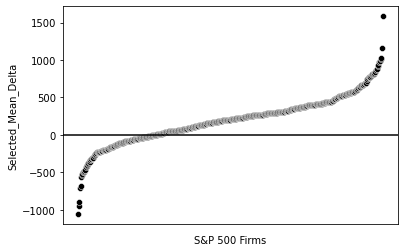

In [364]:
# Plot difference between selected dimensions for firms. 

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

g1 = sns.scatterplot(data = company_names.sort_values(by=["Selected_Mean_Delta"], ascending=True), x = "Name", y = "Selected_Mean_Delta", color = "black", ax = ax)
g1.set(xticklabels=[]) 
g1.set(xlabel="S&P 500 Firms") 
g1.axhline(0, color = "black")
g1.tick_params(bottom=False)  

In [365]:
len(company_names[company_names["Selected_Mean_Delta"] > 0])/len(company_names)

0.7465346534653465

In [366]:
company_names[company_names["Selected_Mean_Delta"] == company_names["Selected_Mean_Delta"].max()]

,Symbol,Name,Sector,Name_Lower,Selected_Mean_Delta
499,XYL,Xylem,Industrials,xylem,1584.96573


In [367]:
# Analyze companies with highest difference meaning highest bias toward female embedding. 

company_names.sort_values(by=["Selected_Mean_Delta"], ascending=False).head(10).reset_index(drop = True)

,Symbol,Name,Sector,Name_Lower,Selected_Mean_Delta
0,XYL,Xylem,Industrials,xylem,1584.965730
1,INTU,Intuit,Information Technology,intuit,1158.537293
2,NUE,Nucor,Materials,nucor,1030.015237
3,ADI,Analog Devices,Information Technology,analog devices,1009.555233
4,AMAT,Applied Materials,Information Technology,applied materials,993.592642
5,WM,Waste Management,Industrials,waste management,991.190863
6,AIZ,Assurant,Financials,assurant,978.845559
7,ALLE,Allegion,Industrials,allegion,934.488695
8,INTC,Intel,Information Technology,intel,921.404741
9,SYK,Stryker Corporation,Health Care,stryker corporation,876.317985


<AxesSubplot:xlabel='Selected_Mean_Delta', ylabel='Sector'>

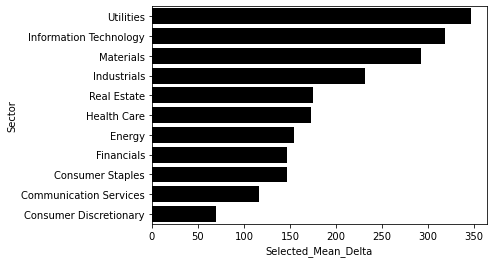

In [368]:
# Check for difference between sectors. 

sp_500_groupedby_industry = company_names.groupby("Sector").mean().sort_values(by=["Selected_Mean_Delta"], 
                                                                        ascending=False)
sns.barplot(data = sp_500_groupedby_industry, y = sp_500_groupedby_industry.index, 
            x= "Selected_Mean_Delta", color = "black")